# ResNet Implementation

Kurz-Erklärung:

- ResNet = Regelmäßige Layer-Skips: Ein Convolutional Encoder-Decoder (bzw Bottleneck) Block erhält als Eingabe die addierten Ausgaben der beiden vorherigen Blöcke.

- ResNeXt = ResNet aber mit mehreren separaten Streams: Die Eingabe wird intern mit mehreren kleineren Layer parallel verarbeitet und später für den Layer-Skip zusammengeführt.

![ResNet & ResNeXt](resnext_block.png)

Grafik von Xie et al, "Aggregated Residual Transformations for Deep Neural Networks", 2017, arXiv:1611.05431v2

In [ ]:
!pip install pandas numpy sklearn matplotlib
!conda install tensorflow-gpu

TODO random state setzen? <https://stackoverflow.com/a/52897289>

## Daten

Die Daten bestehen aus 28x28 Bilder in einer CSV-Datei. Die erste Spalte enthält das Label und alle anderen Spalten sind die Helligkeit des jeweiligen Pixels als Byte.

In [3]:
import pandas as pd
X_train = pd.read_csv("data/sign_mnist_train.csv")
X_test = pd.read_csv("data/sign_mnist_test.csv")

# reduce training data because it is too computationally expensive for us
X_train = X_train.iloc[:10000]

# separate label column
y_train = X_train.pop('label')
y_test = X_test.pop('label')

# values are 0-255 right now, scale them to 0.0-1.0 instead
X_train = X_train.divide(255)
X_test = X_test.divide(255)

# rearrange from 1d to 3d (w,h,c)
# we have no colour channels, so duplicate the brightness
import numpy as np
X_train = np.tile(np.expand_dims(X_train.to_numpy().reshape(-1,28,28),axis=3),3)
X_test = np.tile(np.expand_dims(X_test.to_numpy().reshape(-1,28,28),axis=3),3)

# label is category, convert to one-hot vector
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_train)
label_binarizer.fit(y_test)
y_train = label_binarizer.transform(y_train)
y_test = label_binarizer.transform(y_test)
labels_amount = len(y_train[0])

# imagenet weights want 1000 classes
y_train = np.pad(y_train, ((0,0),(0,1000-labels_amount)))
y_test = np.pad(y_test, ((0,0),(0,1000-labels_amount)))

print(f"Amount of samples: Train {len(y_train)} vs. Test {len(y_test)}")
print(f'Amount of distinct labels: {labels_amount}')

Amount of samples: Train 10000 vs. Test 7172
Amount of distinct labels: 24


**TODO should we scale images to (224, 224, 3) somehow?** (without actually resizing them individually, which has proven as a surefire method of frying the cpu)

<https://keras.io/api/applications/resnet/#resnet50v2-function>

In [ ]:
#import imutils
#import numpy as np

#X_train_big = []
#for row in np.tile(np.expand_dims(X_train.to_numpy(),axis=2),3):
#    X_train_big.append( imutils.resize(row.reshape(28,28,3),height=224,width=224) )

## Training

ResNet wird mittlerweile von Keras als fertige Architektur angeboten.

In [1]:
from tensorflow.keras.applications import ResNet50V2

model = ResNet50V2()  # weights=None,classes=labels_amount)

# https://keras.rstudio.com/reference/compile.html
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [3]:
model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

Da es sehr viele (25,568,360) trainierbare Parameter gibt, dauert das Training dementsprechend lange. Der Datensatz wird auf 10,000 Samples reduziert, damit das lokale Training einer Periode nicht länger als eine halbe Stunde dauert.

Damit nicht jedes mal neu trainiert werden muss, können stattdessen an dieser Stelle Gewichte geladen werden. Der Trainingsverlauf kann auch gespeichert werden.

In [2]:
model.load_weights('data/resnet_weights.h5')

import pickle
with open('data/resnet_history.pickle', 'rb') as file_pi:
    history = pickle.load(file_pi)

Das Training kann ruhig im Hintergrund laufen. Es sind zwar nur wenige Epochen vorgesehen, die dauern aber dennoch 2-3 Stunden (mit schwacher GPU).

In [4]:
callback = model.fit(X_train, y_train, epochs = 10, validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 1132s 5s/step - loss: 2.3801 - accuracy: 0.4611 - val_loss: 21.3203 - val_accuracy: 0.5685
Epoch 2/10
250/250 [==============================] - 1140s 5s/step - loss: 0.7555 - accuracy: 0.7865 - val_loss: 75.7948 - val_accuracy: 0.7260
Epoch 3/10
250/250 [==============================] - 1142s 5s/step - loss: 0.5556 - accuracy: 0.8558 - val_loss: 0.1477 - val_accuracy: 0.9515
Epoch 4/10
250/250 [==============================] - 1153s 5s/step - loss: 0.2036 - accuracy: 0.9440 - val_loss: 2.8662 - val_accuracy: 0.4755
Epoch 5/10
250/250 [==============================] - 1141s 5s/step - loss: 0.4442 - accuracy: 0.9035 - val_loss: 0.8168 - val_accuracy: 0.8030
Epoch 6/10
250/250 [==============================] - 1145s 5s/step - loss: 0.2552 - accuracy: 0.9408 - val_loss: 0.0462 - val_accuracy: 0.9775
Epoch 7/10
250/250 [==============================] - 1144s 5s/step - loss: 0.0941 - accuracy: 0.9743 - val_loss: 0.4693 - val_accurac

Die Gewichte und Trainingsverlauf werden anschließend gespeichert, um wie zuvor erwähnt wiederverwendet werden zu können.

In [8]:
model.save_weights('data/resnet_weights.h5')

history = callback.history
# https://stackoverflow.com/a/44674337
import pickle
with open('data/resnet_history.pickle', 'wb') as file_pi:
    pickle.dump(history, file_pi)

## ResNet Überprüfen

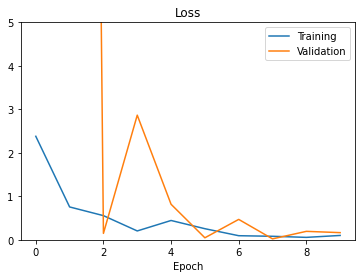

In [39]:
import matplotlib.pyplot as plt

plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.gca().set_ylim([0, 5]) # Sonderfall, Spitze abschneiden
plt.legend()
plt.show()

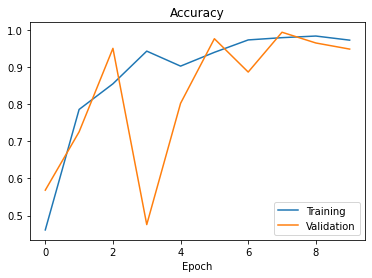

In [4]:
plt.plot(history['accuracy'], label='Training')
plt.plot(history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [5]:
model.evaluate(X_test, y_test)

225/225 [==============================] - 100s 442ms/step - loss: 0.4704 - accuracy: 0.8702


[0.47039681673049927, 0.8701896071434021]

In [48]:
# Kopie von Anfang, kann beim zusammengeführten Notebook gelöscht werden
def plot_confusion_matrix(y_test, y_pred):
    labels = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']
    y_test_abc = [np.argmax(y) for y in y_test]
    y_pred_abc = [np.argmax(y) for y in y_pred]

    from sklearn.metrics import confusion_matrix
    cn = confusion_matrix(y_test_abc, y_pred_abc)

    import seaborn as sns
    ax = sns.heatmap(data = cn,
                     annot = True,
                     fmt = 'g',
                     xticklabels = labels,
                     yticklabels = labels)

    ax.set(xlabel = 'Predicted', ylabel = 'Ground Truth')

    import matplotlib.pyplot as plt
    fig = plt.gcf()
    fig.set_size_inches(10,7)
    plt.close(fig) # do not show automatically
    return fig

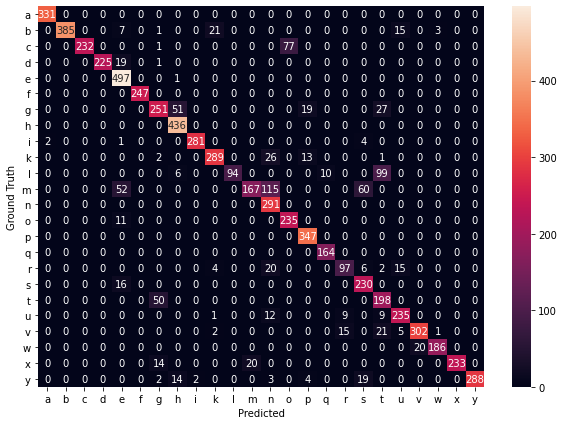

In [47]:
y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)

- L => Daumen vertikal, Zeigefinger horizontal
- T => Daumen horizontal, Zeigefinger vertikal
- G => Daumen versteckt, Zeigefinger vertikal
- M, N, und S sind jeweils eine Faust mit unterschiedlicher Daumenstellung

## ResNet Conclusio

Es dauert ziemlich lange, ResNet zu trainieren. Die Trainingszeit kann durch Reduktion der Trainingsdaten verkürzt werden, allerdings besteht dann die Gefahr des Overfittings.

Trotz der wenigen Epochen und verringerter Datenmenge ist das Ergebnis passabel. Das Netzwerk ist eindeutig noch nicht fertig trainiert. Stünden mehr Ressourchen zur Verfügung, könnte es zu einem hervorragenden Ergebnis führen.